In [1]:
# Install required packages if not already done
# !pip install pandas numpy matplotlib statsmodels

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM

In [3]:
# Load the data
df = pd.read_csv("commodity_prices.csv")
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)


In [4]:
# Select relevant commodities
data = df[['sugar_world', 'coffee_arabica']]
data = data.dropna()

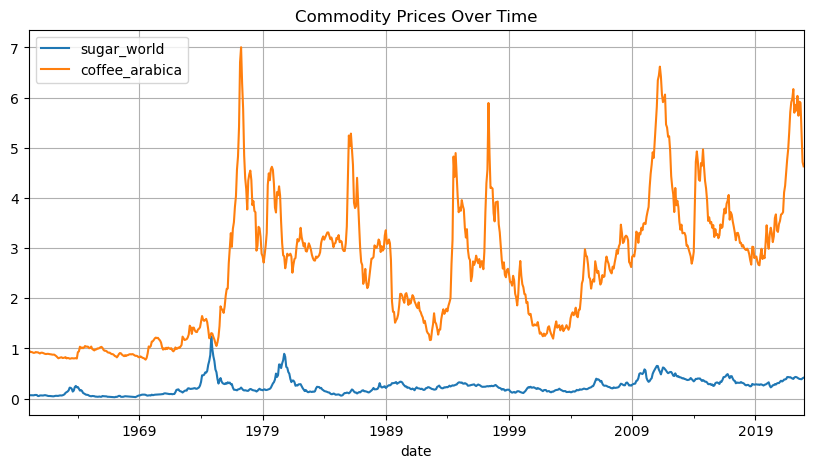

In [5]:
# Plot the raw series
data.plot(title="Commodity Prices Over Time", figsize=(10, 5))
plt.grid(True)
plt.show()


In [6]:
# ADF Test Function
def adf_test(series, name):
    result = adfuller(series)
    print(f"ADF Test for {name}:")
    print(f"  Test Statistic = {result[0]:.4f}")
    print(f"  p-value = {result[1]:.4f}")
    print("  Stationary" if result[1] < 0.05 else "  Non-stationary")
    print("")

In [7]:

# Run ADF Test
for col in data.columns:
    adf_test(data[col], col)

ADF Test for sugar_world:
  Test Statistic = -3.8258
  p-value = 0.0027
  Stationary

ADF Test for coffee_arabica:
  Test Statistic = -3.2910
  p-value = 0.0153
  Stationary



In [8]:

# First difference the data
data_diff = data.diff().dropna()


In [9]:
# ADF on differenced data
print("After First Differencing:\n")
for col in data_diff.columns:
    adf_test(data_diff[col], col)


After First Differencing:

ADF Test for sugar_world:
  Test Statistic = -9.0326
  p-value = 0.0000
  Stationary

ADF Test for coffee_arabica:
  Test Statistic = -9.0239
  p-value = 0.0000
  Stationary



In [10]:
# Check for cointegration using Johansen test
cj = coint_johansen(data, det_order=0, k_ar_diff=1)
print("Eigenvalues:\n", cj.lr1)
print("Critical values (95%):\n", cj.cvt[:, 1])

Eigenvalues:
 [32.18732559  7.59163686]
Critical values (95%):
 [15.4943  3.8415]


In [11]:

# Fit VAR Model
model_var = VAR(data_diff)
selected_lag = model_var.select_order(maxlags=12).aic
results_var = model_var.fit(selected_lag)
print(results_var.summary())


C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 24, Jul, 2025
Time:                     22:22:27
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -9.65786
Nobs:                     745.000    HQIC:                  -9.81770
Log likelihood:           1622.22    FPE:                4.92839e-05
AIC:                     -9.91794    Det(Omega_mle):     4.66187e-05
--------------------------------------------------------------------
Results for equation sugar_world
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                      0.000296         0.001147            0.258           0.797
L1.sugar_world             0.291251         0.036876            7.898           0.000
L1.coffee_arabica         -0.00130

In [12]:
# Forecast with VAR
forecast = results_var.forecast(data_diff.values[-selected_lag:], steps=12)
forecast_df = pd.DataFrame(forecast, columns=data.columns)

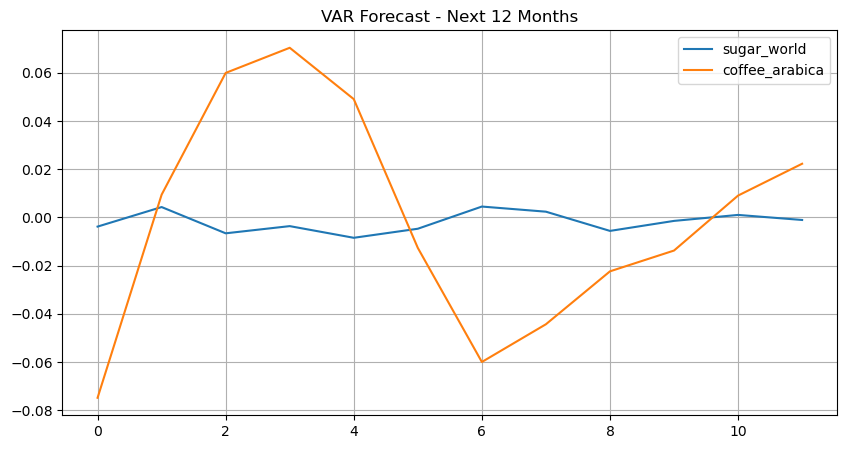

In [13]:
# Plot forecast
forecast_df.plot(title="VAR Forecast - Next 12 Months", figsize=(10, 5))
plt.grid(True)
plt.show()


In [14]:
# If cointegrated, fit VECM
vecm_model = VECM(data, k_ar_diff=1, coint_rank=1)
vecm_res = vecm_model.fit()
print("VECM Fitted Summary:")
print(vecm_res.summary())

VECM Fitted Summary:
Det. terms outside the coint. relation & lagged endog. parameters for equation sugar_world
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
L1.sugar_world        0.2579      0.035      7.335      0.000       0.189       0.327
L1.coffee_arabica    -0.0044      0.005     -0.861      0.389      -0.015       0.006
Det. terms outside the coint. relation & lagged endog. parameters for equation coffee_arabica
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
L1.sugar_world        0.0257      0.241      0.107      0.915      -0.446       0.498
L1.coffee_arabica     0.2732      0.035      7.757      0.000       0.204       0.342
            Loading coefficients (alpha) for equation sugar_world             
                 coef    st

C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
